In [24]:
# http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [26]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt    
from scipy import signal as sig

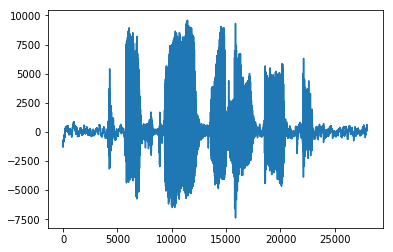

In [18]:
sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
plt.plot(signal)

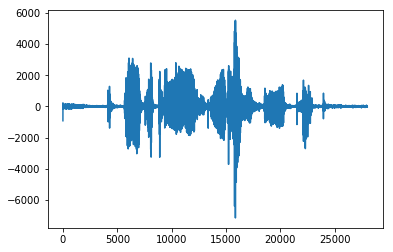

In [19]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plt.plot(emphasized_signal)

In [5]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

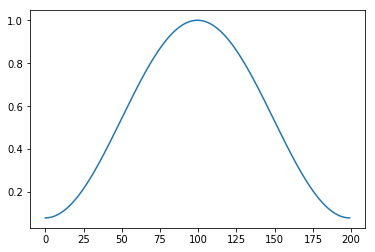

In [21]:
frames *= numpy.hamming(frame_length)
plt.plot(numpy.hamming(frame_length))

In [8]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

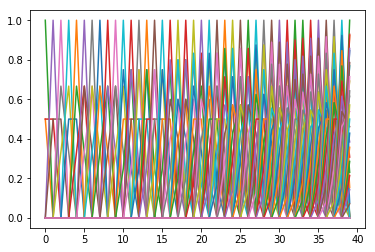

In [23]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
plt.plot(fbank)

In [12]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [14]:
cep_lifter = 22
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

In [15]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

Text(0.5,1,'MFCC')

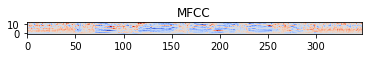

In [70]:

mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
numpy.shape(mfcc)
fig, ax = plt.subplots()
from matplotlib import cm
mfcc_data= numpy.swapaxes(mfcc, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

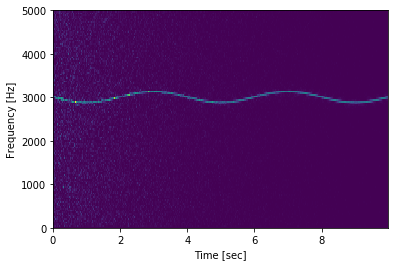

In [64]:
fs = 10e3
N = 1e5
amp = 2 * numpy.sqrt(2)
noise_power = 0.01 * fs / 2
time = numpy.arange(N) / float(fs)
mod = 500*numpy.cos(2*numpy.pi*0.25*time)
carrier = amp * numpy.sin(2*numpy.pi*3e3*time + mod)
noise = numpy.random.normal(scale=numpy.sqrt(noise_power), size=time.shape)
noise *= numpy.exp(-time/5)
x = carrier + noise


f, t, Sxx = sig.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()